# Introdução a Modulação Digital com Áudio

⚠️ Esse codigo não funciona em maquinas virtuais ou no WSL


Sobre esse Laboratório:

- [Setup](#setup)
- [Parametros e Bibliotecas](#parametros-de-configurações)
- [Funções e Metodos](#funções)
- [O Laboratório](#o-laboratório)
    1. [Etapa 1: Compreendendo com a Codificação/Modulação de dados](#etapa-1-compreendendo-com-a-codificaçãomodulação-de-dados)
    1. [Etapa 2: Decodificação](#etapa-2-decodificação)
    1. [Etapa 3: Impacto do Ruído na Comunicação](#etapa-3-impacto-do-ruído-na-comunicação)
    1. [Etapa 4: Decodificação no mundo real](#etapa-4-decodificação-no-mundo-real)



## Setup

⚠️ **Atenção** : Execute o código abaixo **apenas uma vez** para realizar a configuração inicial do ambiente.

In [ ]:
!pip install numpy matplotlib soundfile sounddevice scipy

escolhendo a saida e entrada de audio

In [586]:
import os

import sounddevice as sd
import numpy as np
from scipy.io import wavfile

O comando `sd.query_devices()` listará todas as **entradas** e **saídas** de áudio disponíveis no seu computador. 

A partir dessa lista, identifique qual é a sua **entrada** (microfone) e **saída** (alto-falante) de áudio desejada e atribua esses valores às variáveis `input_device` e `output_device`, respectivamente. Por exemplo,

```
   5 LG ULTRAWIDE (HD Audio Driver f, MME (0 in, 2 out)
   6 Alto-falantes (3- Realtek(R) Au, MME (0 in, 2 out)
>  7 Driver de captura de som primário, Windows DirectSound (2 in, 0 out)
   8 Grupo de microfones (3- Tecnologia Intel® Smart Sound para microfones digitais), Windows DirectSound (2 in, 0 out)
   9 Headset (QCY MeloBuds Pro), Windows DirectSound (1 in, 0 out)
< 10 Driver de som primário, Windows DirectSound (0 in, 2 out)
  11 Fones de ouvido (QCY MeloBuds Pro), Windows DirectSound (0 in, 8 out)
  12 LG ULTRAWIDE (HD Audio Driver for Display Audio), Windows DirectSound (0 in, 2 out)
```

Para que o laboratorio funcione adequamente no meu computador devo escolher opcoes 7 , 10.

In [587]:
sd.query_devices()

  0 Ananda Microphone, Core Audio (1 in, 0 out)
> 1 MacBook Air Microphone, Core Audio (1 in, 0 out)
< 2 MacBook Air Speakers, Core Audio (0 in, 2 out)

In [588]:
output_device = 2
input_device = 1
sd.default.device = (input_device, output_device)

🎯 Execute o código abaixo para gravar um áudio de 3 segundos e, em seguida, reproduzi-lo.

Caso a gravação ou reprodução não funcione corretamente, ajuste os valores das variáveis `input_device` (dispositivo de entrada) e `output_device` (dispositivo de saída) até que o código funcione como esperado.

In [589]:
DURATION = 3  # duraçao em segundos
SAMPLE_RATE = 44100  # Hz
FILENAME = "captura.wav"

audio = sd.rec(int(DURATION * SAMPLE_RATE), samplerate=SAMPLE_RATE, channels=1, dtype='float32')
sd.wait()
print("Gravação finalizada.")

# Salvando arquivo de audio temporario
max_val = np.max(np.abs(audio))
if max_val > 0:
    scaled = audio / max_val
else:
    scaled = audio
wav_data = np.int16(scaled * 32767)
wavfile.write(FILENAME, SAMPLE_RATE, wav_data)
print(f"Áudio salvo em {FILENAME}")

# Reproduz o áudio salvo
fs, data = wavfile.read(FILENAME)
sd.play(data, fs)
sd.wait()
os.remove(FILENAME)
print('Se você escutou o audio tudo seu sistema está configurado corretamente!')

Gravação finalizada.
Áudio salvo em captura.wav
Se você escutou o audio tudo seu sistema está configurado corretamente!


## Parametros de configurações

In [590]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import sounddevice as sd
from scipy import signal
import time

parametros de codificação

In [591]:
##
## configuracoes do audio (detalhes na secção de setup)
##

output_device = 2
input_device = 1
sd.default.device = (input_device, output_device)

##
## Configurações globais do exercio
##
SAMPLE_RATE = 44100  # Taxa de amostragem do audio
BIT_DURATION = 1.0   # 1 segundo por bit
FREQ_LOW = 440       # bit '0' (Lá)
FREQ_HIGH = 880      # bit '1' (Lá oitava)

## Funções

Nessa secao vocês encontraram as funcoes utilizadas

In [592]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import sounddevice as sd
from scipy import signal
import time

### Gerador de tom & visualizacao

In [593]:
def generate_tone(frequency, duration, sample_rate=SAMPLE_RATE):
    """
    Gera um tom senoidal
    
    Args:
        frequency: Frequência em Hz
        duration: Duração em segundos
        sample_rate: Taxa de amostragem
    
    Returns:
        array: Sinal de áudio
    """
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    # Aplica janela para suavizar transições
    tone = np.sin(2 * np.pi * frequency * t)
    # Janela de Hanning para evitar cliques
    window = np.hanning(len(tone))
    return tone * window

In [594]:
def show(data:str,debug):
    if debug==True:
        print(data)

In [595]:
def plot_signal(audio_signal, title, num_bits):
    time_axis = np.linspace(0, len(audio_signal)/SAMPLE_RATE, len(audio_signal))
    
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, audio_signal)
    plt.title(title)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    
    for i in range(1, num_bits): #divisões dos bits
        plt.axvline(x=i*BIT_DURATION, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

### Codificadores

In [596]:
def encode_nrz(data_bits,debug=False):
    """
    Codifica dados usando NRZ
    
    Args:
        data_bits: string de bits (ex: "10110")
    
    Returns:
        array: Sinal de áudio codificado
    """
    audio_signal = np.array([])
    
    show(f"Codificando NRZ: {data_bits}",debug)
    
    for i, bit in enumerate(data_bits):
        if bit == '1':
            freq = FREQ_HIGH
            show(f"Bit {i}: '1' -> {freq} Hz",debug)
        else:
            freq = FREQ_LOW
            show(f"Bit {i}: '0' -> {freq} Hz",debug)
        
        tone = generate_tone(freq, BIT_DURATION)
        audio_signal = np.concatenate([audio_signal, tone])
    
    return audio_signal

In [597]:
def encode_nrzi(data_bits,debug=False):
    """
    Codifica dados usando NRZI
    
    Args:
        data_bits: string de bits
    
    Returns:
        array: Sinal de áudio codificado
    """
    audio_signal = np.array([])
    show(f"Codificando NRZI: {data_bits}", debug)

    current_level = '1'

    for i, bit in enumerate(data_bits):
        if bit == '1':
            # Bit '1': inverte o nível atual
            current_level = '0' if current_level == '1' else '1'
            show(f"Bit {i}: '1' -> inverte para {current_level}", debug)
        else:
            # Bit '0': mantém o nível atual
            show(f"Bit {i}: '0' -> mantém {current_level}", debug)

        # Gera o tom baseado no nível atual
        freq = FREQ_HIGH if current_level == '1' else FREQ_LOW
        tone = generate_tone(freq, BIT_DURATION)
        audio_signal = np.concatenate([audio_signal, tone])

    return audio_signal

In [598]:
def encode_manchester(data_bits,debug=False):
    """
    Codifica dados usando Manchester
    
    Args:
        data_bits: string de bits
    
    Returns:
        array: Sinal de áudio codificado
    """
    audio_signal = np.array([])
    
    show(f"Codificando Manchester: {data_bits}",debug)
    
    for i, bit in enumerate(data_bits):
        if bit == '1':
            # Bit '1': alto->baixo (primeira metade alta, segunda baixa)
            tone1 = generate_tone(FREQ_HIGH, BIT_DURATION/2)
            tone2 = generate_tone(FREQ_LOW, BIT_DURATION/2)
            show(f"Bit {i}: '1' -> {FREQ_HIGH}Hz -> {FREQ_LOW}Hz",debug)
        else:
            # Bit '0': baixo->alto (primeira metade baixa, segunda alta)
            tone1 = generate_tone(FREQ_LOW, BIT_DURATION/2)
            tone2 = generate_tone(FREQ_HIGH, BIT_DURATION/2)
            show(f"Bit {i}: '0' -> {FREQ_LOW}Hz -> {FREQ_HIGH}Hz",debug)
        
        bit_signal = np.concatenate([tone1, tone2])
        audio_signal = np.concatenate([audio_signal, bit_signal])
    
    return audio_signal

### Decodificadores

#### Detector de frequência

Neste trecho de código, vamos utilizar a **Transformada Rápida de Fourier (FFT)** para detectar frequências dominantes em segmentos de áudio — uma ferramenta para análise espectral de sinais. Utilizamos esse conceito em sala de aula para ilustrar o conceito de **modulação por divisão de frequência (FDM)**. Esse codigos detectaram os bits `0` e `1` em razão das fequências que estabelessemos. 

A função `detect_frequency` tem como objetivo identificar as frequências que compõem um sinal de áudio modulado. Na Figura 1, vemos duas senoides (uma azul e uma vermelha), representando frequências distintas associadas aos bits `'0'` e `'1'`. Essas senoides são combinadas para formar o sinal apresentado na Figura 2, o qual será analisado.


| Figura 1 | Figura 2 | 
| :-:   | :-: |
| 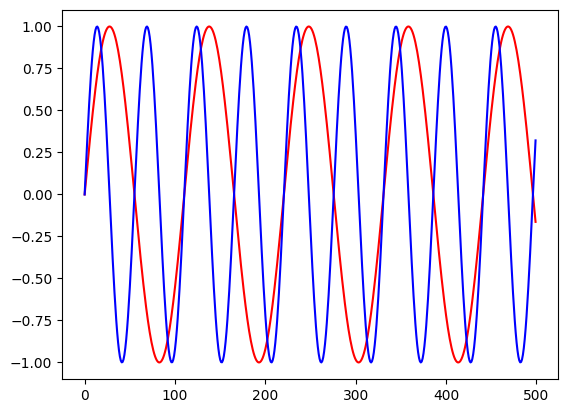 | 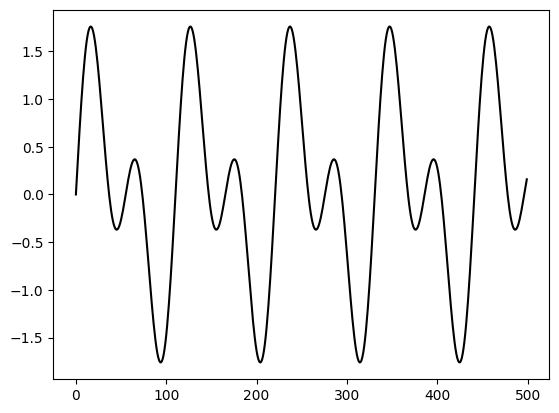 |

O código utiliza a FFT para detectar os picos de frequência presentes no sinal composto. Esses picos — visíveis no gráfico espectral gerado pela FFT (Figura 3) — correspondem exatamente às componentes originais da modulação, permitindo que cada segmento de áudio seja interpretado como `'0'` ou `'1'` com base em qual frequência está presente.

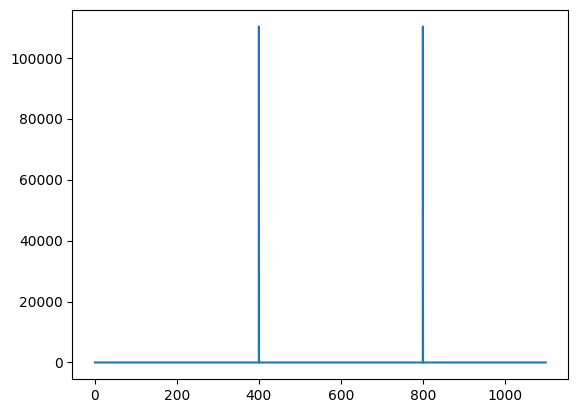

Assim como vimos em sala de aula, essa abordagem ilustra o processo de demodulação por frequência, fundamental no modelo de transmissão FDM (Frequency Division Multiplexing).

Já a função `frequency_to_bit` interpreta a frequência detectada como um bit binário, comparando-a com um limiar: se for superior ao valor definido, retorna `'1'`; caso contrário, `'0'`. Esse processo simula uma decodificação simples de sinais FDM com base na presença de faixas de frequência distintas.


🔧 **Observação**: valores como `SAMPLE_RATE` e o `threshold` devem estar de acordo com as frequências utilizadas (ja configurados no inicio do notebook) durante a modulação para garantir a correta detecção dos dados transmitidos.

In [599]:
def detect_frequency(audio_segment, sample_rate=SAMPLE_RATE):
    """
    Detecta a frequência dominante em um segmento de áudio
    
    Args:
        audio_segment: Segmento de áudio
        sample_rate: Taxa de amostragem
    
    Returns:
        float: Frequência detectada
    """
    # FFT para análise espectral
    fft = np.fft.fft(audio_segment)
    freqs = np.fft.fftfreq(len(fft), 1/sample_rate)
    
    # Considera apenas frequências positivas
    magnitude = np.abs(fft[:len(fft)//2])
    freqs_positive = freqs[:len(freqs)//2]
    
    # Encontra o pico de frequência
    peak_idx = np.argmax(magnitude)
    detected_freq = abs(freqs_positive[peak_idx])
    
    return detected_freq

def frequency_to_bit(frequency, threshold=660):
    """
    Converte frequência detectada em bit
    
    Args:
        frequency: Frequência detectada
        threshold: Limiar para decisão (média entre FREQ_LOW e FREQ_HIGH)
    
    Returns:
        str: '0' ou '1'
    """
    return '1' if frequency > threshold else '0'

#### Decoders

In [600]:
def decode_nrz(audio_signal, num_bits, sample_rate=SAMPLE_RATE,debug=False):
    """
    Decodifica sinal NRZ
    
    Args:
        audio_signal: Sinal de áudio
        num_bits: Número esperado de bits
        sample_rate: Taxa de amostragem
    
    Returns:
        str: Bits decodificados
    """
    samples_per_bit = int(sample_rate * BIT_DURATION)
    decoded_bits = ""
    
    show("Decodificando NRZ:",debug)
    
    for i in range(num_bits):
        start_idx = i * samples_per_bit
        end_idx = start_idx + samples_per_bit
        
        if end_idx > len(audio_signal):
            show(f"Aviso: Áudio muito curto para {num_bits} bits",debug)
            break
        
        # Analisa o meio do bit para evitar transições
        mid_start = start_idx + samples_per_bit // 4
        mid_end = end_idx - samples_per_bit // 4
        segment = audio_signal[mid_start:mid_end]
        
        freq = detect_frequency(segment, sample_rate)
        bit = frequency_to_bit(freq)
        decoded_bits += bit
        
        show(f"Bit {i}: freq={freq:.1f}Hz -> '{bit}'",debug)
    
    return decoded_bits

In [601]:
def decode_nrzi(audio_signal, num_bits, sample_rate=SAMPLE_RATE, debug=False):
    """
    Decodifica sinal NRZI
    """
    samples_per_bit = int(sample_rate * BIT_DURATION)
    decoded_bits = ""
    show("Decodificando NRZI:", debug)

    last_level = '1'

    for i in range(num_bits):
        start_idx = i * samples_per_bit
        end_idx = start_idx + samples_per_bit

        if end_idx > len(audio_signal):
            show(f"Aviso: Áudio muito curto para {num_bits} bits", debug)
            break

        mid_start = start_idx + samples_per_bit // 4
        mid_end = end_idx - samples_per_bit // 4
        segment = audio_signal[mid_start:mid_end]

        freq = detect_frequency(segment, sample_rate)
        level = '1' if freq > 660 else '0'

        # NRZI: se o nível mudou em relação ao anterior, bit é '1', senão '0'
        bit = '1' if level != last_level else '0'
        decoded_bits += bit
        show(f"Bit {i}: freq={freq:.1f}Hz -> nível {level} (anterior {last_level}) -> '{bit}'", debug)
        last_level = level

    return decoded_bits

In [602]:
def decode_manchester(audio_signal, num_bits, sample_rate=SAMPLE_RATE,debug=False):
    """
    Decodifica sinal Manchester
    """
    samples_per_bit = int(sample_rate * BIT_DURATION)
    decoded_bits = ""
    
    show("Decodificando Manchester:",debug)
    
    for i in range(num_bits):
        start_idx = i * samples_per_bit
        end_idx = start_idx + samples_per_bit
        
        if end_idx > len(audio_signal):
            break
        
        # Analisa primeira e segunda metade do bit
        mid_point = start_idx + samples_per_bit // 2
        
        # Primeira metade
        first_half = audio_signal[start_idx + samples_per_bit//8 : mid_point - samples_per_bit//8]
        freq1 = detect_frequency(first_half, sample_rate)
        state1 = frequency_to_bit(freq1)
        
        # Segunda metade
        second_half = audio_signal[mid_point + samples_per_bit//8 : end_idx - samples_per_bit//8]
        freq2 = detect_frequency(second_half, sample_rate)
        state2 = frequency_to_bit(freq2)
        
        # Determina o bit baseado na transição
        if state1 == '1' and state2 == '0': # Alto -> Baixo
            bit = '1'  
            show(f"Bit {i}: {freq1:.1f}Hz -> {freq2:.1f}Hz = alto->baixo = '1'",debug)
        elif state1 == '0' and state2 == '1': # Baixo -> Alto
            bit = '0'  
            show(f"Bit {i}: {freq1:.1f}Hz -> {freq2:.1f}Hz = baixo->alto = '0'",debug)
        else: # Erro de decodificação
            bit = '?'  
            show(f"Bit {i}: {freq1:.1f}Hz -> {freq2:.1f}Hz = ERRO na transição",debug)
        
        decoded_bits += bit
    
    return decoded_bits

## O Laboratório

In [603]:
##
## configuracoes do audio (detalhes na secção de setup)
##

output_device = 2
input_device = 1
sd.default.device = (input_device, output_device)

##
## Configurações globais do exercio
##
SAMPLE_RATE = 44100  # Taxa de amostragem do audio
BIT_DURATION = 1.0   # 1 segundo por bit
FREQ_LOW = 440       # bit '0' (Lá)
FREQ_HIGH = 880      # bit '1' (Lá oitava)

### Etapa 1: Compreendendo com a Codificação/Modulação de dados

Nessa seção você deve se familiariazar com algumas das funções de codificação (modulação) vista em sala de aula

In [604]:
test_bits = "01011110011001"
print(f"Dados originais: {test_bits}\n")

Dados originais: 01011110011001



In [605]:
# Testa cada modulação
print("1. NRZ:")
nrz_signal = encode_nrz(test_bits,debug=True)

print("\n3. Manchester:")
manchester_signal = encode_manchester(test_bits,debug=True)

1. NRZ:
Codificando NRZ: 01011110011001
Bit 0: '0' -> 440 Hz
Bit 1: '1' -> 880 Hz
Bit 2: '0' -> 440 Hz
Bit 3: '1' -> 880 Hz
Bit 4: '1' -> 880 Hz
Bit 5: '1' -> 880 Hz
Bit 6: '1' -> 880 Hz
Bit 7: '0' -> 440 Hz
Bit 8: '0' -> 440 Hz
Bit 9: '1' -> 880 Hz
Bit 10: '1' -> 880 Hz
Bit 11: '0' -> 440 Hz
Bit 12: '0' -> 440 Hz
Bit 13: '1' -> 880 Hz

3. Manchester:
Codificando Manchester: 01011110011001
Bit 0: '0' -> 440Hz -> 880Hz
Bit 1: '1' -> 880Hz -> 440Hz
Bit 2: '0' -> 440Hz -> 880Hz
Bit 3: '1' -> 880Hz -> 440Hz
Bit 4: '1' -> 880Hz -> 440Hz
Bit 5: '1' -> 880Hz -> 440Hz
Bit 6: '1' -> 880Hz -> 440Hz
Bit 7: '0' -> 440Hz -> 880Hz
Bit 8: '0' -> 440Hz -> 880Hz
Bit 9: '1' -> 880Hz -> 440Hz
Bit 10: '1' -> 880Hz -> 440Hz
Bit 11: '0' -> 440Hz -> 880Hz
Bit 12: '0' -> 440Hz -> 880Hz
Bit 13: '1' -> 880Hz -> 440Hz


**Escutando os dados** como a nossa proposta é utilizar notas músicais (som) para representar `0` e `1`. Vamos escutalos.

In [606]:
sd.play(manchester_signal, SAMPLE_RATE)
sd.wait()

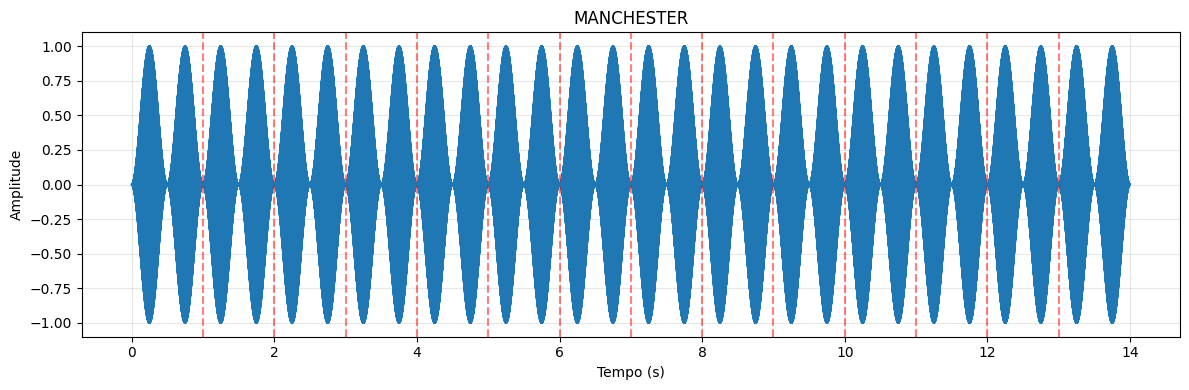

In [607]:
plot_signal(manchester_signal, 'MANCHESTER', len(test_bits))

In [608]:
sd.play(nrz_signal, SAMPLE_RATE)
sd.wait()

Você pode visualizar a modulação utilizando plots, com abaixo

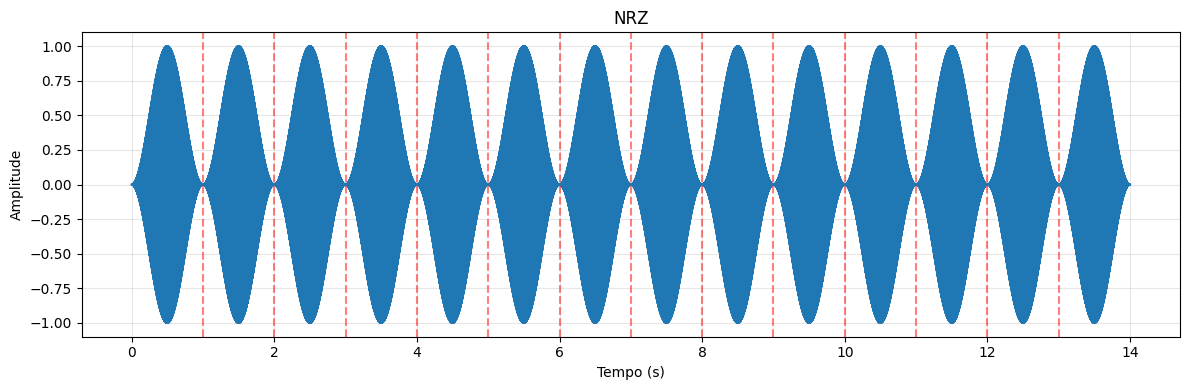

In [609]:
plot_signal(nrz_signal,'NRZ',len(test_bits))

##### Esse modulação foi utilizada nos primórdios da internet (internet discada)

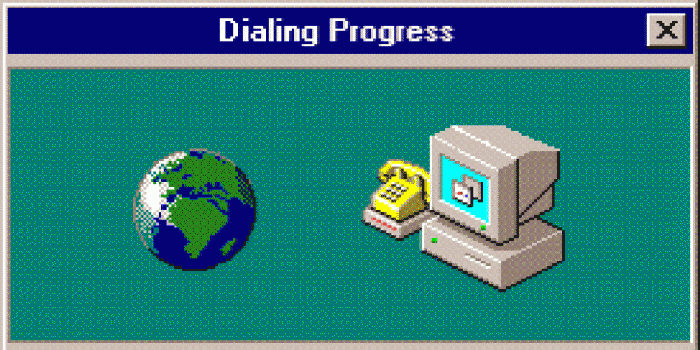

A internet discada utilizava modulação analógica para transportar dados digitais pela linha telefônica. Nos primeiros modems — como os que seguiram o padrão Bell 103 — a técnica predominante foi a Frequency Shift Keying (FSK), onde duas frequências distintas (uma para o bit 0 e outra para o bit 1) eram usadas para representar os dados.

Para quem não teve a oportunidade de utilizar a internet discada o video abaixo ilustra bem o processo de modulação utilizada

<iframe width="560" height="315" src="https://www.youtube.com/embed/ofVEEWObx_I?si=VzAD8hgPPeyXFSRn" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

### Etapa 2: Decodificação

Nesta etapa vocês irão  recuperar os dados originais a partir do sinal de áudio recebido. Este é o papel do receptor em um sistema de comunicação.

O promeiro passo para a decodificação (demodulação) em um mundo ideal é salvar o resultado da modulação em um arquivo de audio (.wav)

In [610]:
# Dados de teste
test_data = "01011110011001"

print(f"Criando arquivos de teste para: {test_data}")

# NRZ
nrz_signal = encode_nrz(test_data)
sf.write('teste_nrz.wav', nrz_signal, SAMPLE_RATE)
print("\t ✓ Arquivo teste_nrz.wav criado")

# Manchester
manchester_signal = encode_manchester(test_data)
sf.write('teste_manchester.wav', manchester_signal, SAMPLE_RATE)
print("\t ✓ Arquivo teste_manchester.wav criado")


Criando arquivos de teste para: 01011110011001
	 ✓ Arquivo teste_nrz.wav criado
	 ✓ Arquivo teste_manchester.wav criado


In [611]:
original_data = test_data

print(f"\nDados originais: {original_data}")
print(f"Número de bits: {len(original_data)}\n")


Dados originais: 01011110011001
Número de bits: 14



Para evitar efeitos de atenuação e interferencias vamos realizar a decodificação diretamente do arquivo de audio.

In [612]:
# Testa decodificação NRZ
print("1. Decodificando NRZ:")
nrz_audio, _ = sf.read('teste_nrz.wav')
decoded_nrz = decode_nrz(nrz_audio, len(original_data))
print(f"Original: {original_data}")
print(f"Decodificado: {decoded_nrz}")
print(f"Correto: {original_data == decoded_nrz}\n")

1. Decodificando NRZ:
Original: 01011110011001
Decodificado: 01011110011001
Correto: True



In [613]:
# Testa decodificação Manchester
print("3. Decodificando Manchester:")
manchester_audio, _ = sf.read('teste_manchester.wav')
decoded_manchester = decode_manchester(manchester_audio, len(original_data))
print(f"Original: {original_data}")
print(f"Decodificado: {decoded_manchester}")
print(f"Correto: {original_data == decoded_manchester}")

3. Decodificando Manchester:
Original: 01011110011001
Decodificado: 01011110011001
Correto: True


### Etapa 3: Impacto do Ruído na Comunicação

Simulação de decodificação em condições adversas, o metodo abaixo simula a adição de ruído ao sinal.

In [614]:
def adicionar_ruido(audio_signal, snr_db=-12):
    """
    Adiciona ruído gaussiano ao sinal
    
    Args:
        audio_signal: Sinal original
        snr_db: Relação sinal-ruído em dB
    
    Returns:
        array: Sinal com ruído
    """
    # Calcula potência do sinal
    signal_power = np.mean(audio_signal ** 2)
    
    # Calcula potência do ruído baseada no SNR
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    
    # Gera ruído gaussiano
    noise = np.random.normal(0, np.sqrt(noise_power), len(audio_signal))
    
    return audio_signal + noise

Para adicionar ruido utilize um valor **negativo** no `snr_db`. Por exemplo se você quiser um ruido de 3db utilize `snr_db=-3` no metodo.

A baixo veja a menssagem original

In [615]:
original_bits = "00111000"

  SNR: -30
  Original: 00111000
  Decodificado: 00111010
  Correto: False



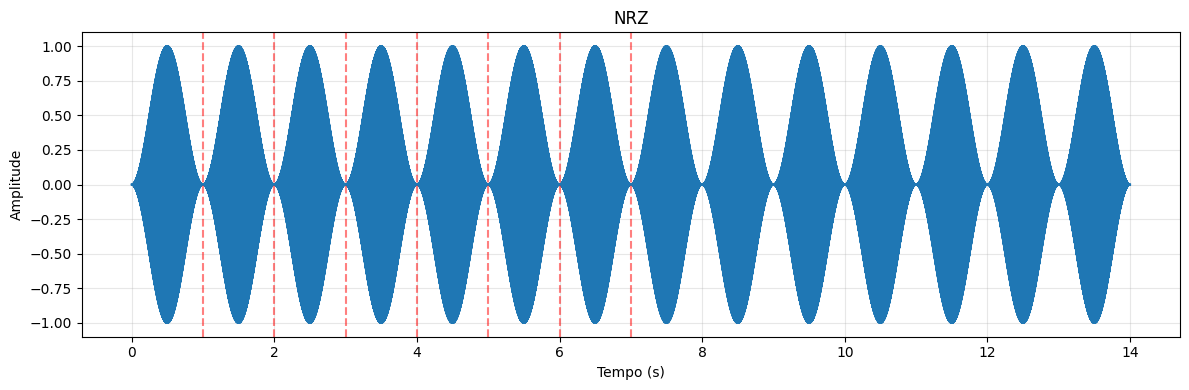

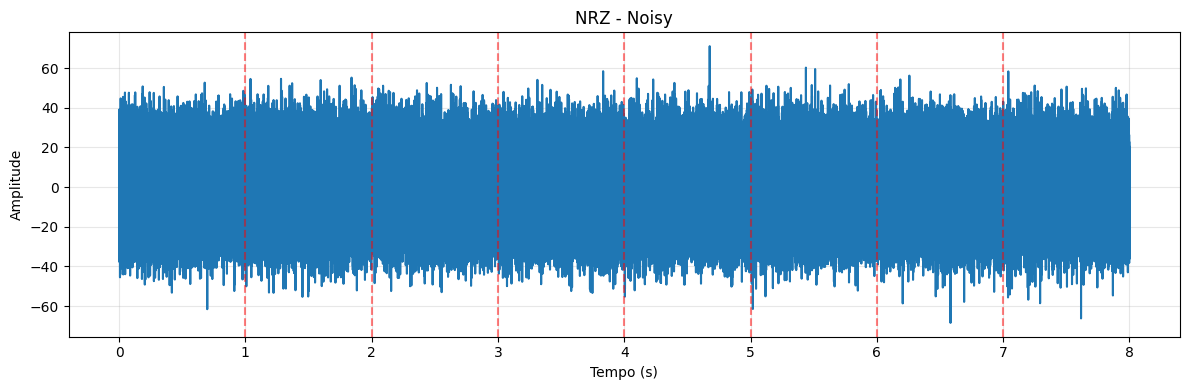

In [616]:
snr=-30

clean_signal = encode_nrz(original_bits)

noisy_signal = adicionar_ruido(clean_signal, snr)
# sd.play(noisy_signal, SAMPLE_RATE)
# sd.wait()
decoded = decode_nrz(noisy_signal, len(original_bits))
print(f"  SNR: {snr}")
print(f"  Original: {original_bits}")
print(f"  Decodificado: {decoded}")
print(f"  Correto: {original_bits == decoded}\n")

plot_signal(nrz_signal,'NRZ',len(original_bits))
plot_signal(noisy_signal, 'NRZ - Noisy', len(original_bits))

  SNR: -28
  Original: 00111000
  Decodificado: 0?111000
  Correto: False



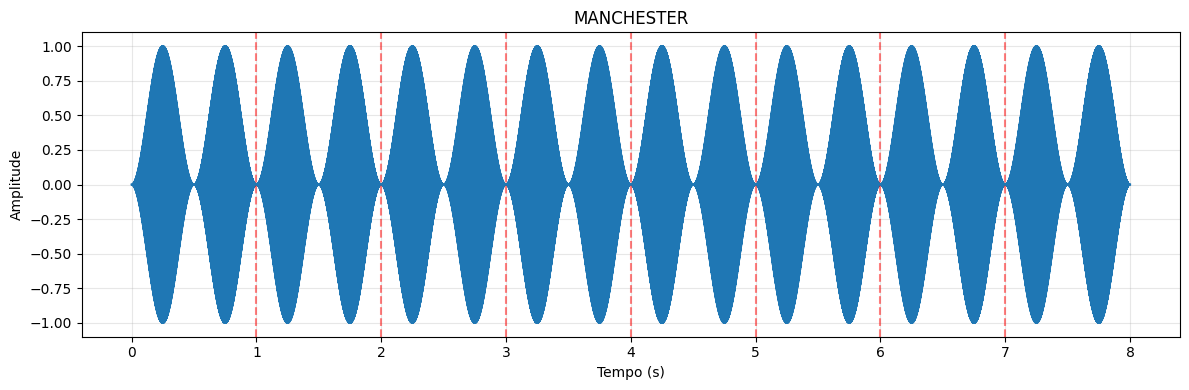

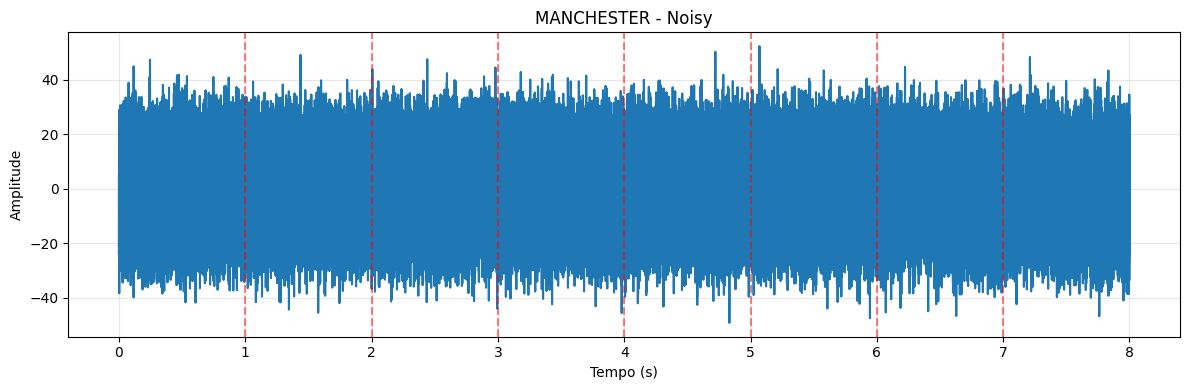

In [630]:
snr=-28

clean_signal = encode_manchester(original_bits)

noisy_signal = adicionar_ruido(clean_signal, snr)
# sd.play(noisy_signal, SAMPLE_RATE)
# sd.wait()
decoded = decode_manchester(noisy_signal, len(original_bits))
print(f"  SNR: {snr}")
print(f"  Original: {original_bits}")
print(f"  Decodificado: {decoded}")
print(f"  Correto: {original_bits == decoded}\n")

plot_signal(clean_signal, 'MANCHESTER', len(original_bits))
plot_signal(noisy_signal, 'MANCHESTER - Noisy', len(original_bits))

  SNR: -30
  Original: 00111000
  Decodificado: 00001000
  Correto: False



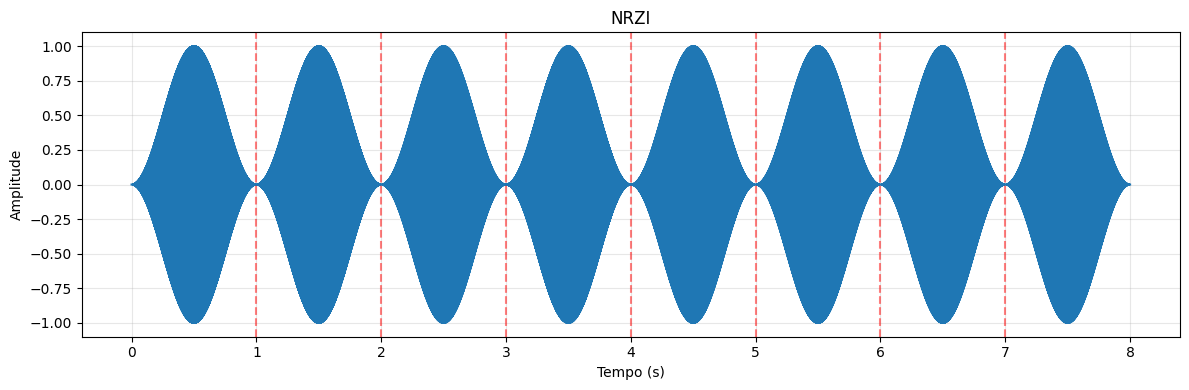

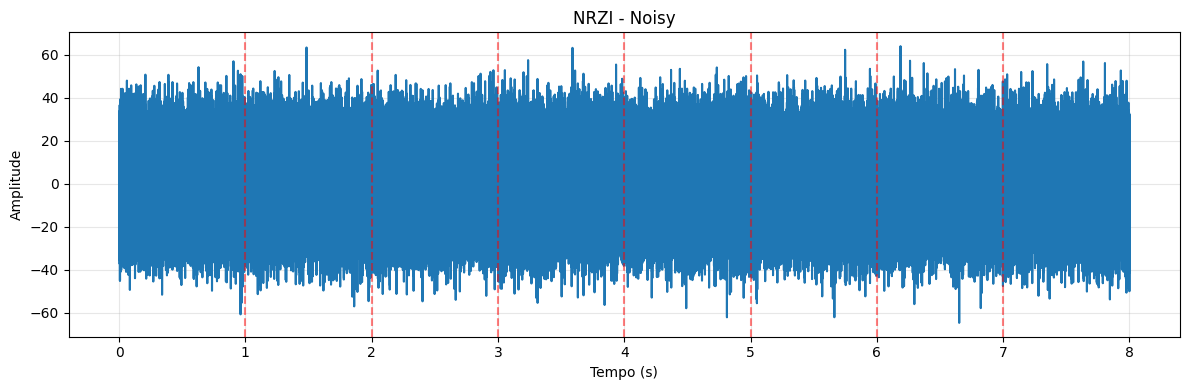

In [638]:
snr=-30

clean_signal = encode_nrzi(original_bits)

noisy_signal = adicionar_ruido(clean_signal, snr)
# sd.play(noisy_signal, SAMPLE_RATE)
# sd.wait()
decoded = decode_nrzi(noisy_signal, len(original_bits))
print(f"  SNR: {snr}")
print(f"  Original: {original_bits}")
print(f"  Decodificado: {decoded}")
print(f"  Correto: {original_bits == decoded}\n")

plot_signal(clean_signal, 'NRZI', len(original_bits))
plot_signal(noisy_signal, 'NRZI - Noisy', len(original_bits))

INICIANDO TESTES DE ROBUSTEZ...
Testes concluídos!


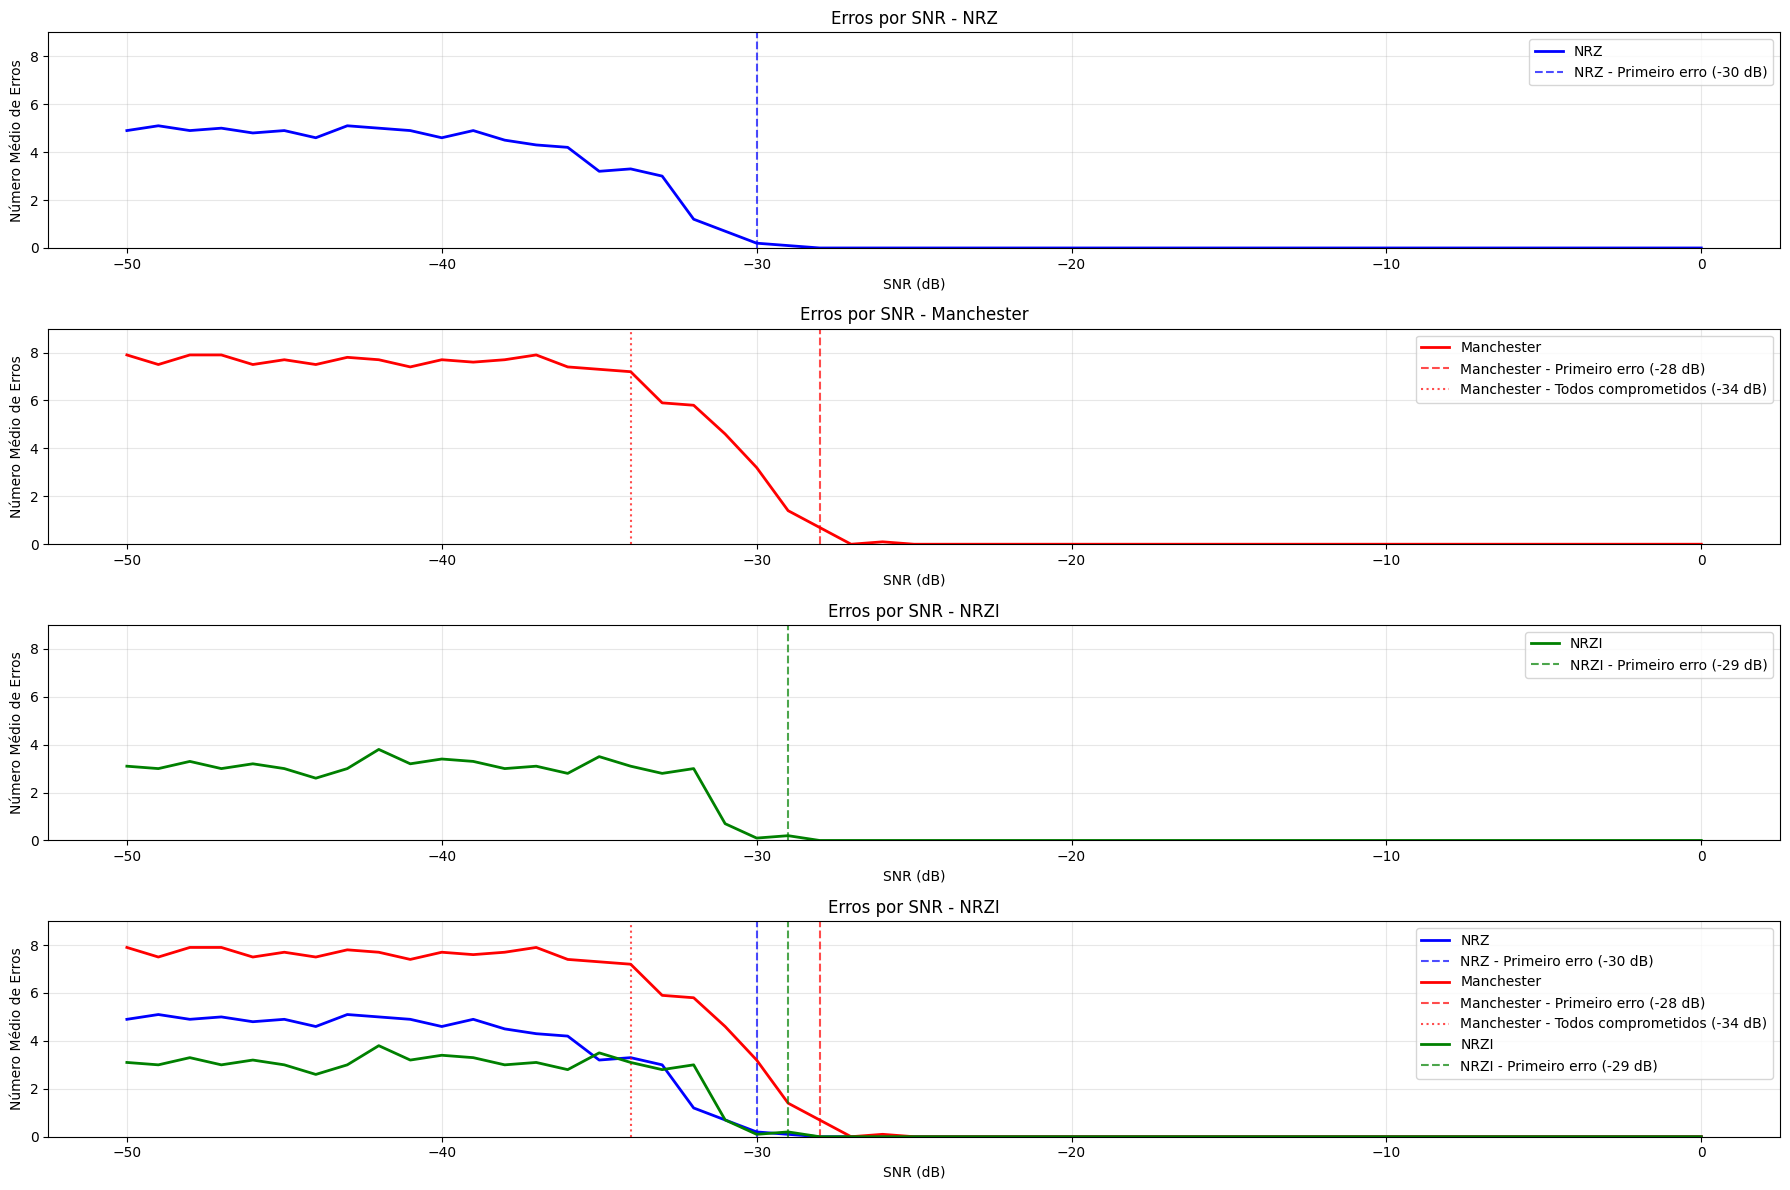


             ANÁLISE DOS RESULTADOS DE ROBUSTEZ AO RUÍDO              
Bits Originais Utilizados: 00111000 (8 bits)
Número de testes por nível de SNR: 10
Intervalo de SNR testado: de 0 dB até -50 dB

RESULTADOS POR MODULAÇÃO:

➤ NRZ (Non-Return to Zero):
   - Primeiro erro percebido em: -30 dB
   - Todos os bits comprometidos em: Não ocorreu

➤ Manchester:
   - Primeiro erro percebido em: -28 dB
   - Todos os bits comprometidos em: -34 dB

➤ NRZI (Non-Return to Zero Inverted):
   - Primeiro erro percebido em: -29 dB
   - Todos os bits comprometidos em: Não ocorreu

                         CONSIDERAÇÕES FINAIS                         

Este teste simulou o desempenho de três modulações digitais (NRZ, Manchester e NRZI)
em diferentes níveis de ruído, controlados via relação sinal-ruído (SNR). A resistência
ao ruído é fundamental para garantir a integridade de dados em ambientes adversos.

➡ A modulação Manchester demonstrou maior resistência ao início da degradação,
   apresentando o p

In [619]:
# Análise de Robustez das Modulações ao Ruído

# Dados de teste
original_bits = "00111000"
snr_values = np.arange(0, -51, -1)
num_tests = 10

# Função para contar erros
def count_errors(original, decoded):
    if len(original) != len(decoded):
        return len(original)
    return sum(1 for a, b in zip(original, decoded) if a != b)

# Resultados para cada modulação
nrz_errors = []
manchester_errors = []
nrzi_errors = []

print("INICIANDO TESTES DE ROBUSTEZ...")
print("=" * 35)

for snr in snr_values:
    nrz_total = man_total = nrzi_total = 0

    for _ in range(num_tests):
        # NRZ
        signal = encode_nrz(original_bits)
        noisy = adicionar_ruido(signal, snr)
        decoded = decode_nrz(noisy, len(original_bits))
        nrz_total += count_errors(original_bits, decoded)

        # Manchester
        signal = encode_manchester(original_bits)
        noisy = adicionar_ruido(signal, snr)
        decoded = decode_manchester(noisy, len(original_bits))
        man_total += count_errors(original_bits, decoded)

        # NRZI
        signal = encode_nrzi(original_bits)
        noisy = adicionar_ruido(signal, snr)
        decoded = decode_nrzi(noisy, len(original_bits))
        nrzi_total += count_errors(original_bits, decoded)

    nrz_errors.append(nrz_total / num_tests)
    manchester_errors.append(man_total / num_tests)
    nrzi_errors.append(nrzi_total / num_tests)

print("Testes concluídos!")

def find_first_error(snr_vals, errors):
    for i, error in enumerate(errors):
        if error > 0.1:
            return snr_vals[i]
    return None

def find_all_errors(snr_vals, errors, total_bits):
    for i, error in enumerate(errors):
        if error >= total_bits * 0.9:
            return snr_vals[i]
    return None

def plot_failure_points(snr_vals, errors, mod_name, color):
    plt.plot(snr_vals, errors, color=color, label=f'{mod_name}', linewidth=2)
    first_error = find_first_error(snr_vals, errors)
    all_error = find_all_errors(snr_vals, errors, len(original_bits))

    if first_error is not None:
        plt.axvline(x=first_error, color=color, linestyle='--', alpha=0.7,
                    label=f'{mod_name} - Primeiro erro ({first_error} dB)')

    if all_error is not None:
        plt.axvline(x=all_error, color=color, linestyle=':', alpha=0.7,
                    label=f'{mod_name} - Todos comprometidos ({all_error} dB)')

    plt.xlabel('SNR (dB)')
    plt.ylabel('Número Médio de Erros')
    plt.title(f'Erros por SNR - {mod_name}')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(0, len(original_bits) + 1)
    
plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plot_failure_points(snr_values, nrz_errors, "NRZ", 'blue')

plt.subplot(4, 1, 2)
plot_failure_points(snr_values, manchester_errors, "Manchester", 'red')

plt.subplot(4, 1, 3)
plot_failure_points(snr_values, nrzi_errors, "NRZI", 'green')

plt.subplot(4, 1, 4)
plot_failure_points(snr_values, nrz_errors, "NRZ", 'blue')
plot_failure_points(snr_values, manchester_errors, "Manchester", 'red')
plot_failure_points(snr_values, nrzi_errors, "NRZI", 'green')

plt.tight_layout()
plt.show()

nrz_first = find_first_error(snr_values, nrz_errors)
nrz_all = find_all_errors(snr_values, nrz_errors, len(original_bits))

man_first = find_first_error(snr_values, manchester_errors)
man_all = find_all_errors(snr_values, manchester_errors, len(original_bits))

nrzi_first = find_first_error(snr_values, nrzi_errors)
nrzi_all = find_all_errors(snr_values, nrzi_errors, len(original_bits))


# ========== RELATÓRIO ==========

print("\n" + "="*70)
print("ANÁLISE DOS RESULTADOS DE ROBUSTEZ AO RUÍDO".center(70))
print("="*70)
print(f"Bits Originais Utilizados: {original_bits} ({len(original_bits)} bits)")
print(f"Número de testes por nível de SNR: {num_tests}")
print(f"Intervalo de SNR testado: de {snr_values[0]} dB até {snr_values[-1]} dB\n")

def format_db(value):
    return f"{value} dB" if value is not None else "Não ocorreu"

# Resultados individuais
print("RESULTADOS POR MODULAÇÃO:\n")

print("➤ NRZ (Non-Return to Zero):")
print(f"   - Primeiro erro percebido em: {format_db(nrz_first)}")
print(f"   - Todos os bits comprometidos em: {format_db(nrz_all)}")

print("\n➤ Manchester:")
print(f"   - Primeiro erro percebido em: {format_db(man_first)}")
print(f"   - Todos os bits comprometidos em: {format_db(man_all)}")

print("\n➤ NRZI (Non-Return to Zero Inverted):")
print(f"   - Primeiro erro percebido em: {format_db(nrzi_first)}")
print(f"   - Todos os bits comprometidos em: {format_db(nrzi_all)}")

# Considerações finais
print("\n" + "="*70)
print("CONSIDERAÇÕES FINAIS".center(70))
print("="*70)

def gerar_consideracoes_finais(nrz_first, man_first, nrzi_first, nrz_all, man_all, nrzi_all):
    texto = "\n"
    texto += ("Este teste simulou o desempenho de três modulações digitais (NRZ, Manchester e NRZI)\n"
              "em diferentes níveis de ruído, controlados via relação sinal-ruído (SNR). A resistência\n"
              "ao ruído é fundamental para garantir a integridade de dados em ambientes adversos.\n\n")
    
    melhores_primeiro_erro = []
    max_first = max(v for v in [nrz_first, man_first, nrzi_first] if v is not None)
    if nrz_first == max_first: melhores_primeiro_erro.append("NRZ")
    if man_first == max_first: melhores_primeiro_erro.append("Manchester")
    if nrzi_first == max_first: melhores_primeiro_erro.append("NRZI")

    melhores_erro_total = []
    if any(x is not None for x in [nrz_all, man_all, nrzi_all]):
        max_all = max(v for v in [nrz_all, man_all, nrzi_all] if v is not None)
        if nrz_all == max_all: melhores_erro_total.append("NRZ")
        if man_all == max_all: melhores_erro_total.append("Manchester")
        if nrzi_all == max_all: melhores_erro_total.append("NRZI")

    # Interpretação baseada nos resultados
    if melhores_primeiro_erro:
        texto += f"➡ A modulação {' e '.join(melhores_primeiro_erro)} demonstrou maior resistência ao início da degradação,\n"
        texto += f"   apresentando o primeiro erro apenas em níveis de ruído mais severos (menor SNR).\n"
    else:
        texto += "➡ Nenhuma modulação apresentou resistência clara ao primeiro erro.\n"

    if melhores_erro_total:
        texto += f"➡ Em relação à resistência ao erro total, {' e '.join(melhores_erro_total)} conseguiram manter\n"
        texto += "   a integridade dos dados mesmo em níveis extremos de ruído, falhando por último.\n"
    else:
        texto += "➡ Nenhuma modulação chegou a comprometer todos os bits; o erro total não foi atingido.\n"

    texto += "\n➡ Recomendação:\n"
    if "Manchester" in melhores_primeiro_erro:
        texto += "- Manchester é indicada para aplicações onde a confiabilidade inicial é essencial,\n"
        texto += "  como em sistemas com correção de erros ou críticos à integridade de dados.\n"
    if "NRZ" in melhores_primeiro_erro or "NRZI" in melhores_primeiro_erro:
        texto += "- NRZ ou NRZI podem ser preferidas em ambientes com ruído moderado, pois são mais simples\n"
        texto += "  de implementar e ocupam menos largura de banda.\n"

    texto += "\n"
    return texto


print(gerar_consideracoes_finais(nrz_first, man_first, nrzi_first, nrz_all, man_all, nrzi_all))

### Etapa 4: Decodificação no mundo real

In [620]:
def capturar_do_microfone(duracao_segundos):
    """
    Captura áudio do microfone
    
    Args:
        duracao_segundos: Duração da captura
    
    Returns:
        array: Áudio capturado
    """
    print(f"Iniciando captura por {duracao_segundos} segundos...")
    print("Reproduza o áudio no seu celular AGORA!")
    
    # Captura áudio
    audio_capturado = sd.rec(
        int(duracao_segundos * SAMPLE_RATE), 
        samplerate=SAMPLE_RATE, 
        channels=1
    )
    sd.wait()  # Aguarda terminar a captura
    
    print("Captura concluída!")
    return audio_capturado.flatten()

In [621]:
import random
import csv


def gerar_string_binaria(n):
    return ''.join(random.choice('01') for _ in range(n))


def gerar_questao(n,start=8,stop=16):
    dados = []
    for i in range(n):
        n_bits = random.randrange(start,stop)
        msg = gerar_string_binaria(n_bits)
        encoder = random.choice([encode_manchester, encode_nrz])
        modulacao = encoder.__name__
        nome = f"dados_{i}_{SAMPLE_RATE}hz.wav"
        sinal = encoder(msg)
        sf.write(nome, sinal, SAMPLE_RATE)
        
        linha = {
            'arquivo':nome,
            'msg': msg,
            'n_bits':n_bits,
            'modulacao':modulacao
        }
        dados.append(linha)
        # print(n_bits,msg,modulacao,nome,len(sinal))
    # print(dados):
    
    nome_arquivo = 'gabarito.csv'

    # Escrita no arquivo CSV
    with open(nome_arquivo, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=dados[0].keys())
        writer.writeheader()
        writer.writerows(dados)



gerar_questao(50)

Para este exercício, você deverá utilizar um **segundo dispositivo**, como por exemplo, seu **celular**.

1. Copie o arquivo de áudio [dados_ar.wav](./dados_ar.wav) para o segundo dispositivo.
2. Este áudio contém uma **mensagem de 5 bits**, codificada utilizando o esquema **Manchester**.
3. O desafio consiste em **decodificar essa mensagem utilizando apenas o microfone do seu computador**.  
   **Não abra o arquivo diretamente** no computador — apenas reproduza o áudio no segundo dispositivo.

> 🧪 Certifique-se de que os [procedimentos de configuração](#setup) foram seguidos corretamente e que o microfone do seu computador está funcionando adequadamente.

Por fim, **execute o código abaixo** (referente à etapa de escuta por microfone) e reproduza o áudio no segundo dispositivo para tentar decodificar a mensagem.

In [629]:
# test_data = "10110"
# Captura áudio

duracao = 5 * BIT_DURATION + 1  # +1 segundo de margem
audio_capturado = capturar_do_microfone(duracao)

# Salva captura para análise
sf.write('captura_microfone.wav', audio_capturado, SAMPLE_RATE)

# Tenta decodificar
print("\nTentando decodificar...")
decoded = decode_manchester(audio_capturado, 5)

print(f"Original: ?????")
print(f"Capturado: {decoded}")

Iniciando captura por 6.0 segundos...
Reproduza o áudio no seu celular AGORA!
Captura concluída!

Tentando decodificar...
Original: ?????
Capturado: 10110
